# Managing your content

## Getting Started

In [1]:
import json
from arcgis.gis import *
from IPython.display import display
from getpass import getpass
from arcgis.mapping import WebMap

In [2]:
url = 'https://esrica-ncr.maps.arcgis.com/home'
user_name = 'fancelin_ncr'
user_password = getpass()

········


In [3]:
gis = GIS(url, user_name, user_password, verify_cert=True)

## Know yourself

In [4]:
user = gis.users.me
user

<User username:fancelin_ncr>

## Publishing Feature Service Content

### Publishing an item from a local file

No matter what you're publishing, the workflow is always the same. Frist you need to add your items to Portal, then publish it. The full documentation is here: 
 - add item: https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.add
 - publish item: https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html?highlight=publish#arcgis.gis.Item.publish

#### Cleanup the demo folder

In [5]:
folder = [folder for folder in user.folders if folder['title'] == 'Tech Trek 2020'][0]
for item in user.items(folder=folder['title']):
    print('Deleting Items: {}'.format(item.delete()))

#### Add the item to ArcGIS online

In [6]:
data = r'D:\Projects\Tech Trek Training\CanadianBoundaries.gdb.zip'
item_title = 'Canadian Provinces'
published_item = gis.content.add(
    item_properties={'title': item_title, 'type':'File Geodatabase'}, 
    data=data, 
    thumbnail=None, 
    metadata=None, 
    owner=user, 
    folder=folder['title']
)

# The folder option does not work at 1.7. So let's force the move
# published_item.move(folder)

published_item

<Item title:"Canadian Provinces" type:File Geodatabase owner:fancelin_ncr>

#### Publish the service

In [7]:
from IPython.display import display
# Because in this class the service will already exist, I use the overwrite flag. It would be false otherwise.
published_service  = published_item.publish()
display(published_service)

<Item title:"Canadian Provinces" type:Feature Layer Collection owner:fancelin_ncr>

### Replacing existing content

#### Fetch the feature layer from the uploaded item

In [8]:
published_service = gis.content.search(query='title:{}'.format(item_title), item_type='Feature Layer Collection')[0]
published_service

<Item title:"Canadian Provinces" type:Feature Layer Collection owner:fancelin_ncr>

<Item title:"CanadianUpdateData" type:File Geodatabase owner:fancelin_ncr>
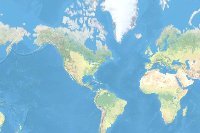

In [9]:
replacement_item_title = 'CanadianUpdateData'
replacement_published_item = gis.content.search(query='title:{}'.format(replacement_item_title), item_type='File Geodatabase')[0]
replacement_published_item

#### Truncating a service

If you're looking for a way to clean all the content of your feature service, then using the truncate method exposed by the REST API and Python is the best way to go:

- REST API: https://developers.arcgis.com/rest/services-reference/truncate-feature-layer-.htm
- Python API: https://developers.arcgis.com/rest/services-reference/truncate-feature-layer-.htm


In [10]:
csd_feature_layer = published_service.layers[0]

Count the number of features in the existing feature layer before truncating

In [11]:
csd_feature_layer.query(where='1=1', return_count_only=True)

575

Truncate

In [12]:
csd_feature_layer.manager.truncate()

{'success': True}

Count the number of features in the existing feature layer after truncating

In [13]:
csd_feature_layer.query(where='1=1', return_count_only=True)

0

#### Populate a layer using append

https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html?highlight=append#arcgis.features.FeatureLayer.append

Perform the append from an existing item

In [14]:
csd_feature_layer.append(item_id=replacement_published_item.id, source_table_name='CSD_2016_Simplified_Quebec', upload_format='filegdb')

True

Count the number of feature after performing the append.

In [15]:
count_result = csd_feature_layer.query(where='1=1', return_count_only=True)

#### Deleting a portion of a feature layer

https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html?highlight=append#arcgis.features.FeatureLayer.delete_features

In [16]:
# return_delete_features is ignored until 1.8
delete_response = csd_feature_layer.delete_features(where="PRNAME = 'Ontario'", return_delete_results=False)
len(delete_response['deleteResults'])

0

#### Updating a few features

One of the problems that come with using the apply edit, is the size of your edit batch. It can creates to kinds of issues:

- Your edits are so big the API will generate a time out, because the server response takes too long to generate.
- The server data is too big, and the API can't serialize everything.

When your get the error message: `The connection was forcibly shut down by the host` you're trying to push a geometry that is too big.

Let's do an update that will trigger a serialization error

In [17]:
with open(r'D:\Projects\Tech Trek Training\CSD_Ontario.json', 'r') as input_file:
    input_features = json.load(input_file)
    input_features_lower = []
    for feature in input_features['features']:
        attributes = {}
        for attribute in feature['attributes'].items():
            if attribute[0].lower() not in ['objectid', 'shape__length', 'shape__area']:
                attributes[attribute[0]] = attribute[1]
        input_features_lower.append({'attributes': attributes, 'geometry': feature['geometry']})
    add_results = csd_feature_layer.edit_features(adds=input_features_lower)
    display(add_results)

{'addResults': [{'objectId': 1285,
   'uniqueId': 1285,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1286,
   'uniqueId': 1286,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1287,
   'uniqueId': 1287,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1288,
   'uniqueId': 1288,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1289,
   'uniqueId': 1289,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1290,
   'uniqueId': 1290,
   'globalId': None,
   'success': False,
   'error': {'code': 1003, 'description': 'Operation rolled back.'}},
  {'objectId': 1291,
   'uniqueId': 1291,
   'globalId': None,

In [18]:
def parse_add_results(edit_result):
    success = True
    for add_result in edit_result['addResults']:
        if not add_result['success']:
            print(add_result)
            success = False
    return success

# Use the version without explicit encoding to emulate serialization issues.
# with open(r'D:\Projects\Tech Trek Training\CSD_Ontario2.json', 'r') as input_file:
with open(r'D:\Projects\Tech Trek Training\CSD_Ontario.json', 'r', encoding="utf-8") as input_file:
    input_features = json.load(input_file)
    input_features_lower = []
    for feature in input_features['features']:
        attributes = {}
        for attribute in feature['attributes'].items():
            if attribute[0].lower() not in ['objectid', 'shape_length', 'shape_area']:
                attributes[attribute[0]] = attribute[1]
        input_features_lower.append({'attributes': attributes, 'geometry': feature['geometry']})
        
        # Adding some logic to send data in batches of 50 features
        if len(input_features_lower) >= 50:
            add_results = csd_feature_layer.edit_features(adds=input_features_lower, rollback_on_failure=False)
            success = parse_add_results(add_results)
#             if not success:
#                 print('Input Feature Error: {}'.format(input_features_lower))
            input_features_lower = []
            
    # Sending the remaining feautre that have been queued but not sent
    if len(input_features_lower) > 0:
        add_results = csd_feature_layer.edit_features(adds=input_features_lower, rollback_on_failure=False)
        parse_add_results(add_results)
        
    print('Done!')

Done!


Counting output features

In [19]:
csd_feature_layer.query(where='1=1', return_count_only=True)

1859

Try to load all the features client-side. We can return as many features as we want.
https://developers.arcgis.com/rest/services-reference/query-feature-service-layer-.htm

In [20]:
csd_feature_layer.query(where='1=1', return_geometry=True, out_fields='*',return_exceeded_limit_features=True)

<FeatureSet> 1859 features

#### Update some features using the calculate fields function.

`calculate(where, calc_expression, sql_format='standard', version=None, sessionid=None, return_edit_moment=None, future=False)`

| Argument | Description |
| --------- | ------------- |
| where| Required String. A where clause can be used to limit the updated records. Any legal SQL where clause operating on the fields in the layer is allowed.|
| calc_expression |	Required List. The array of field/value info objects that contain the field or fields to update and their scalar values or SQL expression. Allowed types are dictionary and list. List must be a list of dictionary objects.|
| sql_format | Optional String. The SQL format for the calc_expression. It can be either standard SQL92 (standard) or native SQL (native). The default is standard.|
| version| Optional String. The geodatabase version to apply the edits.|
| sessionid |Optional String. A parameter which is set by a client during long transaction editing on a branch version. The sessionid is a GUID value that clients establish at the beginning and use throughout the edit session. The sessonid ensures isolation during the edit session. This parameter applies only if the isDataBranchVersioned property of the layer is true.|
| return_edit_moment | Optional Boolean. This parameter specifies whether the response will report the time edits were applied. If true, the server will return the time edits were applied in the response’s edit moment key. This parameter applies only if the isDataBranchVersioned property of the layer is true.|
| future | Optional Boolean. If True, the result is returned as a future object and the results are obtained in an asynchronous fashion. False is the default.|

Source: https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.FeatureLayer.calculate

In [21]:
published_service.layers[1].calculate(
    where = "CountryCode = 'CAN'", 
    calc_expression= {"field": "CountryCode", "value": "CA"}
)

{'success': True, 'updatedFeatureCount': 13}

### Create your own wrapper class to publish a service from an item, and remove the item.

Very often you need to upload an item, publish a service from it and then remove the item once the data has been published as a hosted feature service. You can use the Context Manager Python pattern. All that it takes, it to implement to method __enter__ and __exit__. 

A good documentation is available here: https://www.geeksforgeeks.org/context-manager-in-python/


In [27]:
class AppendItemManager:
    def __init__(self, gis, item_properties, data, folder):
        """
        :param gis: The gis item
        :param item_properties: The item properties for publishing
        :param data: The path to the zipper file
        :param folder: The name of the AGOL folder used for publishing
        """
        self.item = gis.content.add(item_properties=item_properties, data=data, folder=folder)

    def __enter__(self):
        """Called using the with keyword"""
        return self.item

    def __exit__(self, exc_type, exc_value, exc_traceback):
        """Called when exiting the scope of the with keyword."""
        self.item.delete()
        if exc_type:
            return False
        
        
data = r'D:\Projects\Tech Trek Training\CanadianBoundariesTemp.gdb.zip'
item_properties = {'title': 'CanadianProvincesTemp', 'type':'File Geodatabase'}
with AppendItemManager(gis, item_properties=item_properties, data=data, folder='Tech Trek 2020') as item:
    display(item.publish())


<Item title:"CanadianProvincesTemp" type:Feature Layer Collection owner:fancelin_ncr>

## Understand your folder structure

All your items are logically organized into folder when working with ArcGIS. Even, when you did not put an object into folder explicitely, it goes into your root folder.

In [28]:
folders = user.folders
for folder in folders[:3]:
    print (folder['title'])

Backups
BAO - My Sites
Blue Dot Test


Content is accessed by folder. The way of doing this according to the ArcGIS samples

In [29]:
print("Collecting item ids for {}".format(user.username), end="\t\t")
user_content = user.items()

# Get item ids from root folder first
for item in user_content[:3]:
    print('\t\tItem: {}'.format(item['title']))

# Get item ids from each of the folders next
folders = user.folders
for folder in folders[:3]:
    print('\tFolder: {}'.format(folder['title']))
    folder_items = user.items(folder=folder['title'])
    for item in folder_items[:2]:
        print('\t\tItem: {}'.format(item['title']))

		Item: Map Viewer Experience
		Item: StoryMap 1572726444237
	Folder: Backups
		Item: pub_data_20170829-112428.gdb
	Folder: BAO - My Sites
	Folder: Blue Dot Test
		Item: DEVICE_MVMT_PROVTERR_WEEKLY
		Item: DEVICE_MVMT_PROVTERR_WEEKLY


A better ways using generators. A really cool and memory friendly to replace lists. More information on that here: https://www.geeksforgeeks.org/generators-in-python/

In [30]:
def get_folder_items(user):
    yield None, user.items()
    for folder in folders[:3]:
        folder_items = user.items(folder=folder['title'])
        yield folder, items
        
for folder, items in get_folder_items(user):
    folder_title = 'root' if folder is None else folder['title']
    print('\tFolder: {}'.format(folder_title))
    for item in items[:3]:
        print('\t\tItem: {}'.format(item['title']))
    

	Folder: root
		Item: pub_data
		Item: Map Viewer Experience
		Item: StoryMap 1572726444237
	Folder: Backups
		Item: pub_data
		Item: Map Viewer Experience
		Item: StoryMap 1572726444237
	Folder: BAO - My Sites
		Item: pub_data
		Item: Map Viewer Experience
		Item: StoryMap 1572726444237
	Folder: Blue Dot Test
		Item: pub_data
		Item: Map Viewer Experience
		Item: StoryMap 1572726444237


Display the members of one of your group

In [31]:
group = None
for group in user.groups:
    if group.title == 'NRCAN Ice / Flood Working Group':
        display(group)
        break

<Group title:"NRCAN Ice / Flood Working Group" owner:clawlor>

## Transferring Content

There is already a sample explaining the workflow in the documentation. The way of parsing content are not following best practices, but those are demonstrated above. The link is there: https://developers.arcgis.com/python/sample-notebooks/move-existing-user-content-to-a-new-user/



**<font color=red>There is an issue in the sample and the documentation regarding how to remove a user from one of your group.</font>**

According to the documentation, here is how the function `group.remove_users` it is supposed to work: https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Group.remove_users

| Argument | Description |
| -------- | ----------- |
| usernames | Required string. A comma-separated list of users to be removed.

Removing user 
 - according to samples and documentation: `grp.remove_users(orig_userid)`
 - how it actually works as of 1.8.0: `remove_message = grp.remove_users([orig_userid])`

## Understand the relationship between your maps and your feature services

### Make a simple web map

In [32]:
# Create an empty web map with a default basemap
web_map = WebMap()
web_map.definition

{
  "baseMap": {
    "baseMapLayers": [
      {
        "id": "defaultBasemap",
        "layerType": "ArcGISTiledMapServiceLayer",
        "url": "https://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer",
        "visibility": true,
        "opacity": 1,
        "title": "World Topographic Map"
      }
    ],
    "title": "Topographic"
  },
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  },
  "version": "2.10",
  "authoringApp": "ArcGISPythonAPI",
  "authoringAppVersion": "1.7.0"
}

Modify the properties

In [33]:
web_map_properties = {'title':'Provinces of Canada',
                     'snippet':'We are the north',
                     'tags':'ArcGIS Python API, Canada, Provinces'}

Add our provinces to the map

In [34]:
for layer in published_service.layers:
    if layer.properties['name'] == 'Provinces_Territories':
        web_map.add_layer(layer)

Save the web map

In [35]:
web_map_item = web_map.save(item_properties=web_map_properties, folder='Tech Trek 2020')
web_map_item

<Item title:"Provinces of Canada" type:Web Map owner:fancelin_ncr>

<font color=red>**If you are calling save, you will save the item multiple times**: Be very careful here! Use web_map.update from now on after reloading the map from the item id</font>

### Updating Web Map Content

Updating the map properties. **See the map on AGOL before running those changes**

In [36]:
web_map = WebMap(web_map_item)
web_map.definition['operationalLayers'][0]['title'] = 'Provinces And Territories'
web_map.definition['operationalLayers'][0]['popupInfo']['title'] = 'Provinces And Territories'
web_map.definition['operationalLayers'][0]['popupInfo']['fieldInfos'][0]['visible'] = False 
web_map.definition['operationalLayers'][0]['popupInfo']['fieldInfos'][1]['visible'] = False 
web_map.update(item_properties=web_map.definition)

True

### Let's change the item

<Item title:"CanadianUpdateData" type:Feature Layer Collection owner:fancelin_ncr>
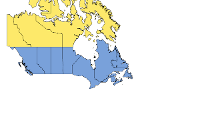

In [37]:
other_feature_service_id = '08b76bc126344267ab405e0e4f75dc90'
other_published_item = gis.content.get(other_feature_service_id)
other_published_item

In [38]:
web_map.definition['operationalLayers'][0]['itemId'] = other_feature_service_id
web_map.definition['operationalLayers'][0]['url'] = '{}/0'.format(other_published_item.url)
web_map.update(item_properties=web_map.definition)
# web_map.definition['operationalLayers'][0]

True

Let's update with a feature that has a slightly different schema. You'll see that this results in some inconsistencies.

In [39]:
web_map.definition['operationalLayers'][0]['itemId'] = other_feature_service_id
web_map.definition['operationalLayers'][0]['url'] = '{}/1'.format(other_published_item.url)
web_map.update(item_properties=web_map.definition)

True

Let's replace the layers using a cleaner way. But you'll see that you're losing your field maps.

You may have multiple reasons to update content. Some services may have migrated from one server to another, or you want to keep an old resource, but have your current map stop using it.


In [40]:
web_map.remove_layer(web_map.layers[0])
web_map.update(item_properties=web_map.definition)

True

In [41]:
web_map.add_layer(other_published_item.layers[1])
web_map.update(item_properties=web_map.definition)

True